In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

## Parâmetros

In [2]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

# fig preprocessing
largura = 150
altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [3]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

,image,target
0,./PokemonData/Moltres/217497a4bc574c1c852e79f3...,Moltres
1,./PokemonData/Rhydon/a1f1aeb89afe4c499046dff03...,Rhydon
2,./PokemonData/Gyarados/79622e7cfd424ed5a8f97fd...,Gyarados
3,./PokemonData/Arbok/22033fc3bf8c48f287d1534421...,Arbok
4,./PokemonData/Alolan Sandslash/c8f9e306eac943c...,Alolan Sandslash
...,...,...
6820,./PokemonData/Primeape/a145758fc1954a128a76c79...,Primeape
6821,./PokemonData/Golem/d7e1bb3415344ec7878369e50a...,Golem
6822,./PokemonData/Doduo/93ed1a6b5eb140a9b7bbbf9541...,Doduo
6823,./PokemonData/Golem/533555d167ba4f588d9d18ad31...,Golem


## Analisando Dados

In [4]:
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


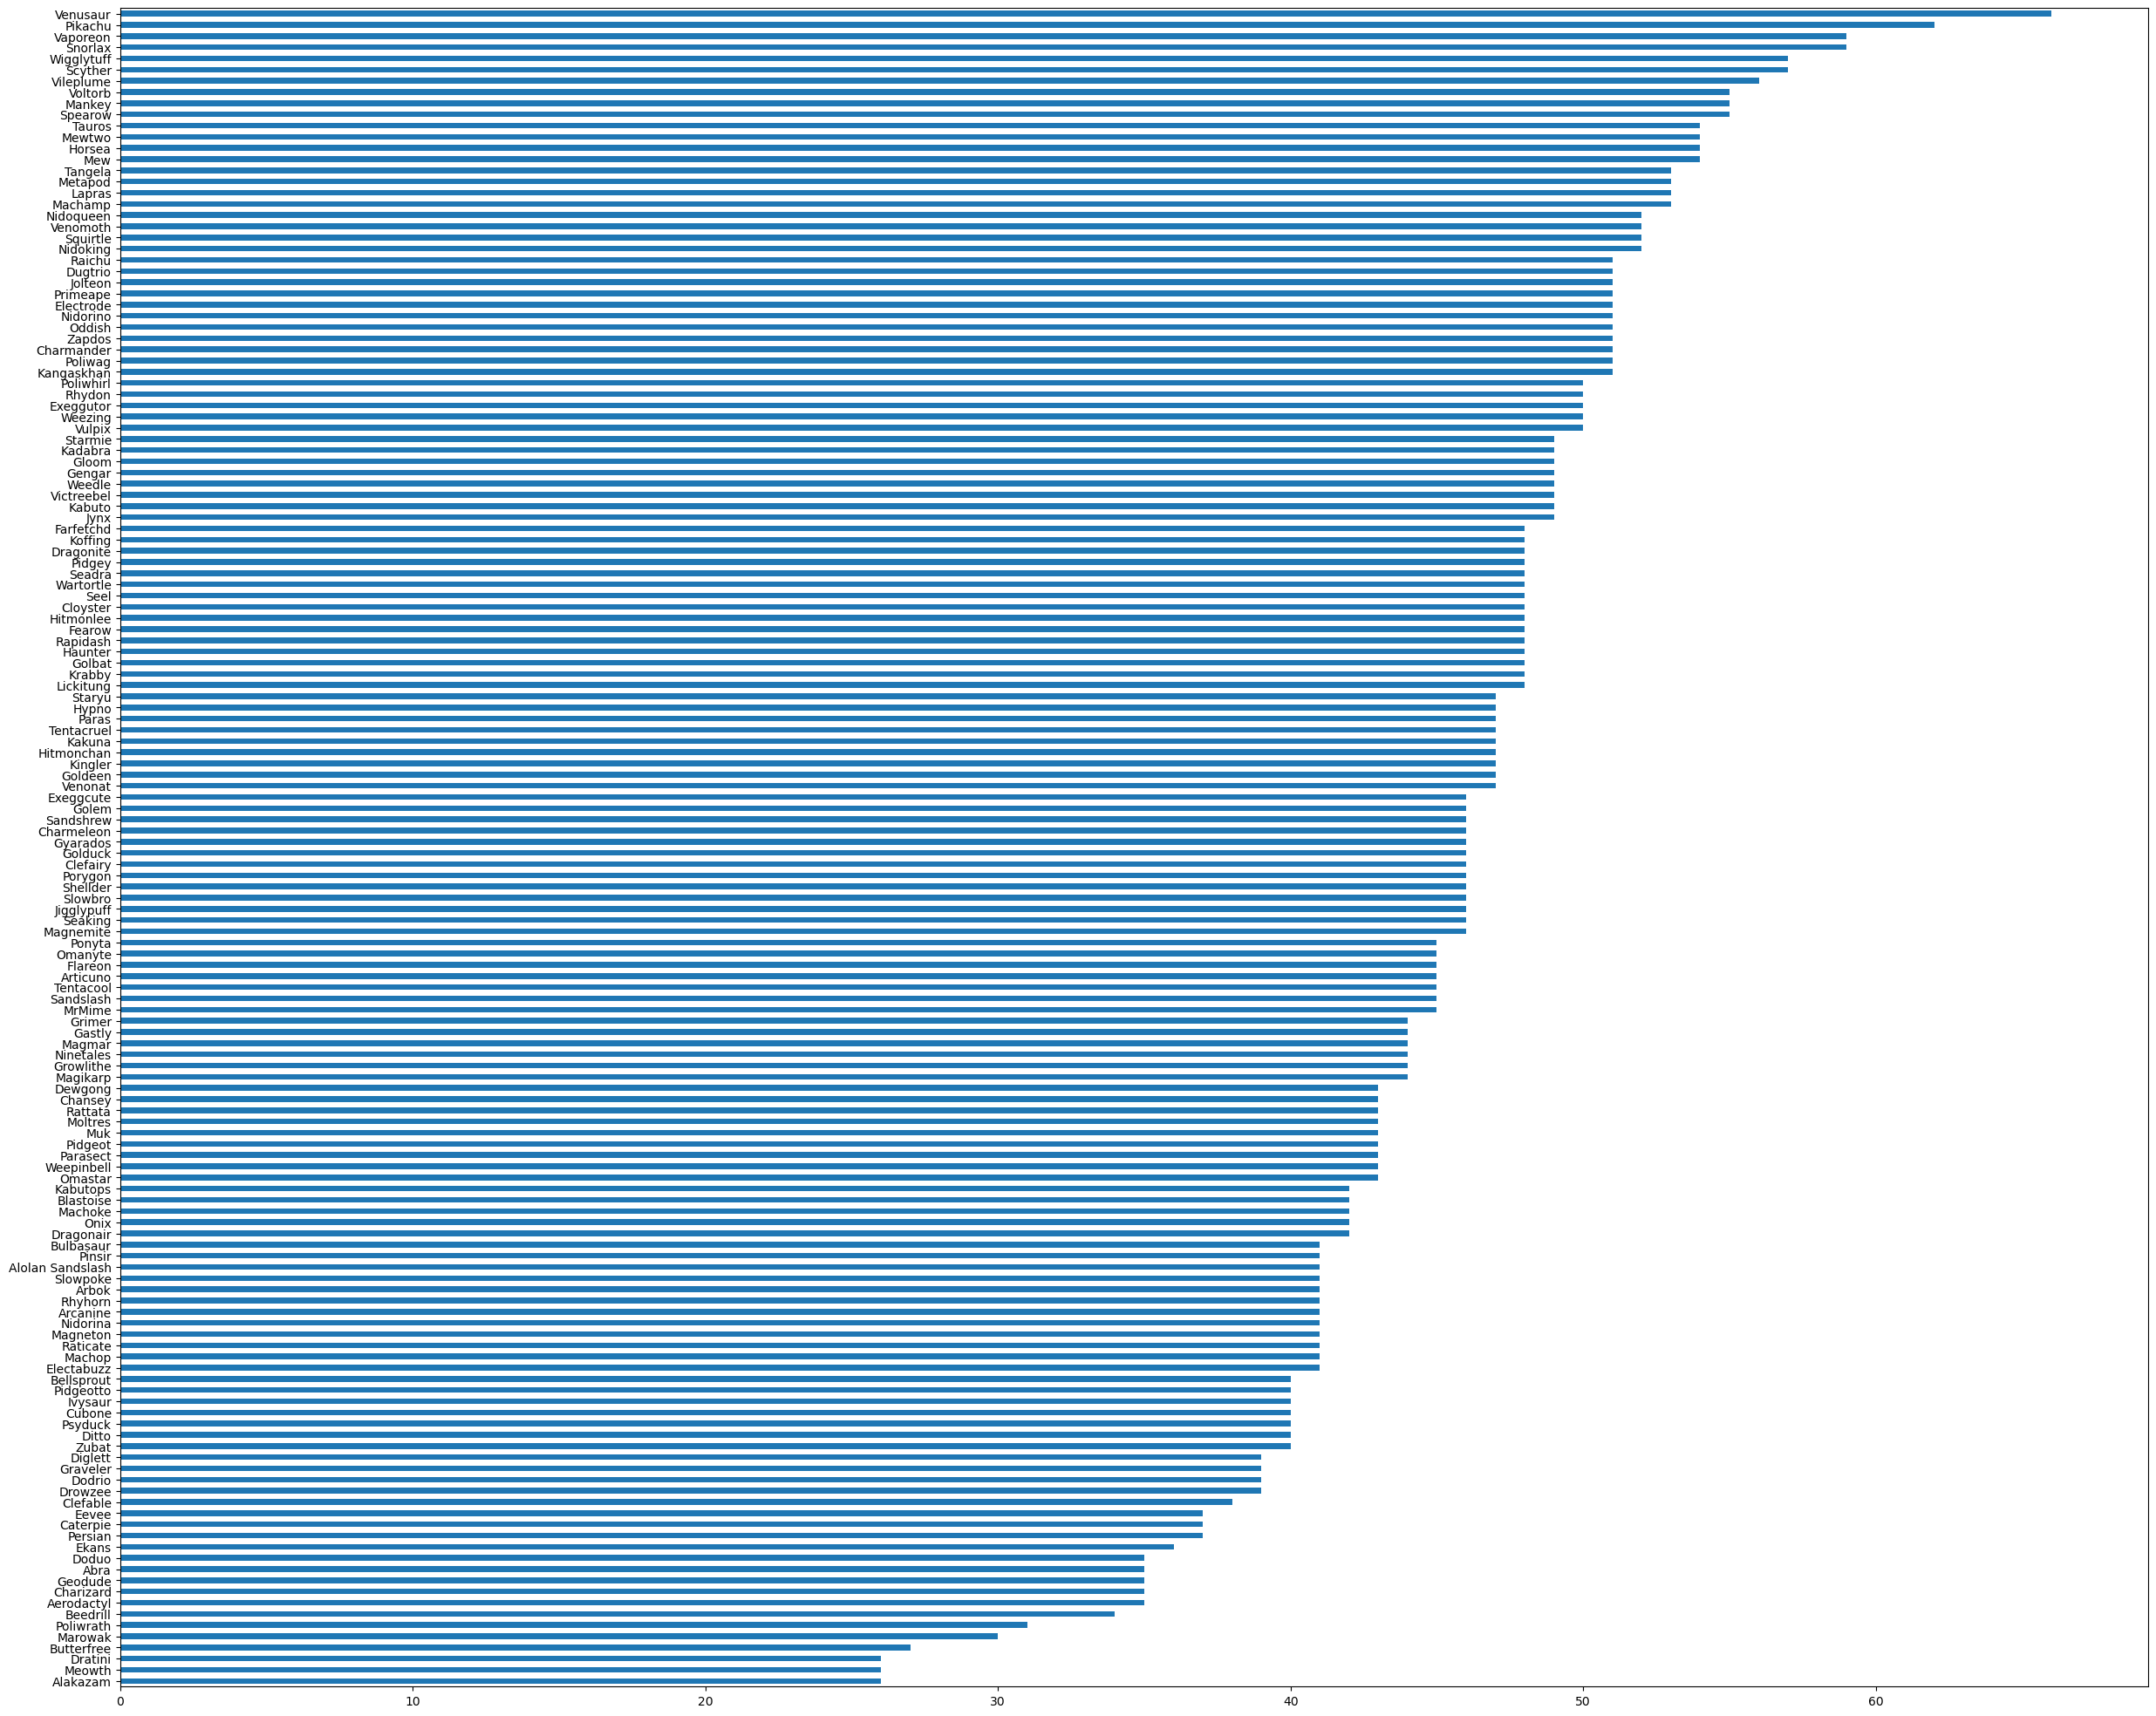

In [5]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [35]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

In [36]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [37]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [44]:
largura = math.floor(mean_width)
altura = math.floor(mean_height)

pixels = []

for filename in df_dados['image']:
    img = image.load_img(filename, target_size=(largura, altura),color_mode= modo_de_cor)
    
    # converter a imagem em uma matriz numpy
    img_array = np.array(img)
    # adicionar a matriz de pixels
    pixels.append(img_array)
    
# converter a lista de pixels em uma matriz numpy
pixels = np.array(pixels)

# achatá-la em uma matriz 2D de pixels
pixels = pixels.reshape(-1, pixels.shape[-1])

plt.figure(figsize=(10,8))
# traçar o histograma dos pixels
plt.hist(pixels.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.8)

plt.xlabel('Valor do pixel')
plt.ylabel('Frequência')
plt.title('Histograma de cores')

plt.show()

## Preparando Dados

In [4]:
def getEmbedder():
    # return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    # return EfficientNetB3(weights='imagenet', include_top=False)
    return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    # return InceptionV3(weights='imagenet', include_top=False)

def embedding(embedder,img_path):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
        # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

embedder = getEmbedder()

71686520/71686520 [==============================] - 5s 0us/step


In [5]:
target = df_dados['target'].array

array_features = []
for x in dados:
    array_features.append(embedding(embedder,x[0]))

1/1 [==============================] - 0s 335ms/step


In [6]:
scaler = preprocessing.StandardScaler()

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

,0,1,2,3,4,5,6,7,8,9,...,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791
0,-0.500722,-0.065590,-0.149641,-0.838962,-0.539606,-0.519662,0.151899,-0.464325,-0.533143,0.099006,...,-0.488209,0.215227,1.676183,-0.199951,-0.392878,0.218109,-0.223882,0.515025,0.725885,-0.022753
1,-0.801258,0.244062,1.145106,-0.545347,0.263273,0.337488,-0.216169,0.211768,1.986008,1.255503,...,-0.742516,-0.769419,-0.859315,-0.764932,-0.752188,-0.488526,3.158576,-0.594263,0.163284,-0.894820
2,0.845667,-0.107522,-0.051292,-0.567372,-0.028554,-0.581987,2.059980,0.583773,-0.161012,-0.017720,...,0.286322,-0.600690,-0.783766,-0.076533,0.344695,-0.390048,0.110679,0.507101,-0.452718,-0.026219
3,-0.786461,0.690691,-0.467056,0.298788,-0.027633,0.019746,2.464433,-0.456992,-0.523871,0.789311,...,0.457401,-0.767047,-0.769146,0.615712,0.582105,-0.383618,-0.478278,-0.370051,-0.767641,0.440539
4,-0.039876,-0.131055,-0.395084,-0.722781,-0.636065,-0.899348,-0.972768,-0.352412,-0.401563,-0.648656,...,-0.432890,0.596857,0.399850,-0.592553,-0.547214,-0.349172,-0.436644,-0.274365,0.542297,-0.139313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,0.935589,-0.859102,-0.282836,-0.658752,-0.484041,-0.458685,0.756239,-0.238786,-0.617029,0.126859,...,-0.489058,-0.220890,2.359506,0.081756,-0.184168,2.817400,-0.236046,-0.583054,-0.826309,1.545484
6821,-0.538699,-0.877014,-0.478627,-0.744641,-0.622422,-0.736347,-0.059204,-0.262978,-0.612988,0.218017,...,-0.827376,-0.695246,2.175518,-0.881978,-0.024406,-0.249170,-0.473613,-0.421758,-0.825489,0.073548
6822,-0.054900,-0.879004,0.031152,-0.902930,0.070912,-0.796416,0.955618,-0.105771,-0.608737,-0.279323,...,0.570372,0.593449,-0.102097,1.099456,0.628036,-0.156490,-0.395630,-0.584769,0.243066,-1.076484
6823,-0.941120,-0.685225,-0.301765,0.805164,-0.321754,1.029188,0.606981,-0.430453,-0.253340,-0.359092,...,-0.596438,-0.757378,-0.430324,-0.590094,-0.788220,-0.441966,-0.044969,-0.601386,-0.515991,-0.627536


## Reduzindo a Dimensionalidade

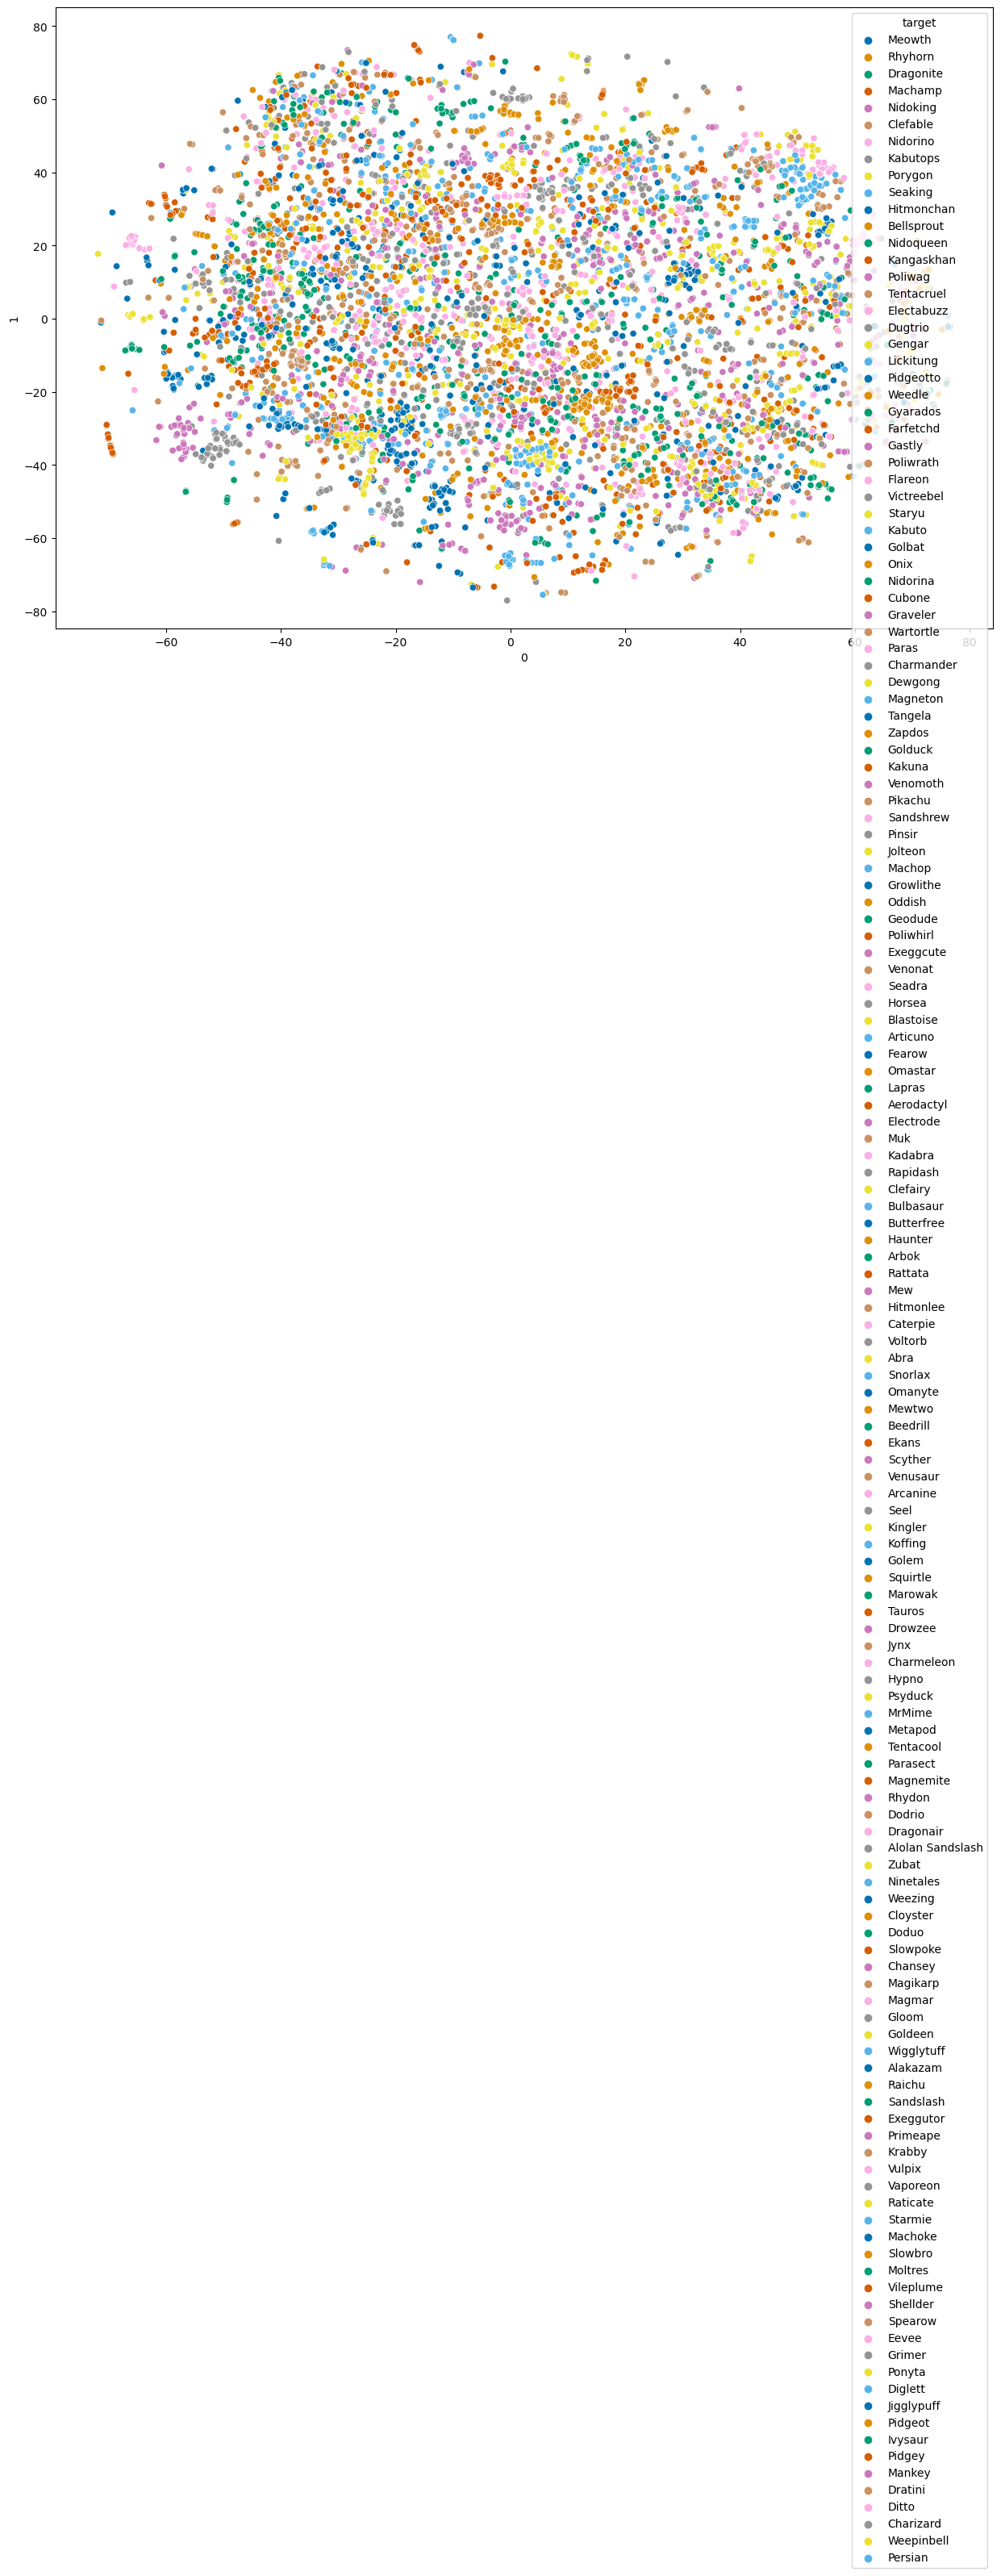

In [7]:
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15)
array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target

plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.show()

## Treinando e Validando o Modelo

In [8]:
def getModel():
    return RandomForestClassifier(n_jobs=20)
    # return LogisticRegression()#n_jobs=20, solver='sag', multi_class='ovr')
    # return KNeighborsClassifier(n_neighbors=3,n_jobs=20)
    # return XGBClassifier()
    # return SGDClassifier(n_jobs=20,early_stopping=True,validation_fraction=0.05)

In [9]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target,test_size=percentege_test_size)

model = getModel().fit(X_treino, y_treino)

score = model.score(X_teste, y_teste)

score

0.32893772893772893

## Validando

In [10]:
scores = cross_val_score(getModel(),df_features.values,target,cv=10)

np.mean(scores)

0.35091669063945086

## Visualizando Matriz de Confusão

In [14]:
predicoes = cross_val_predict(getModel(),df_features.values,target,cv=10)

cm = confusion_matrix(target, predicoes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

KeyboardInterrupt: 